данные взяла https://dano.hse.ru/data2022

**Входные данные:**

датасет предоставлен компанией s7 и представляет собой набор данных о покупках авиабилетов по датам и их характеристики (способы оплаты, пассажиры, сегменты перелета, суммы и т. д.) за некоторый период времени. (файл s7_data_sample.xlsx)

дополнительно используется датасет airports(файл airports.dat) c информацией о кодах аэропорта, его местоположении

Содержание колонок

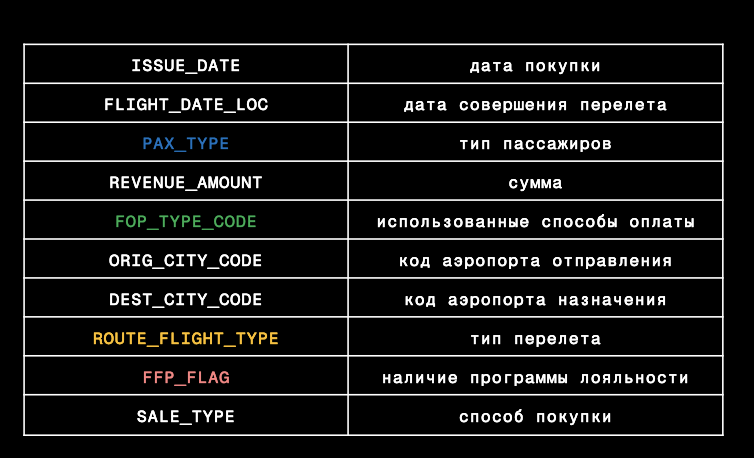

Подробное описание данных https://dano.hse.ru/mirror/pubs/share/796182766

In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [59]:
df = pd.read_excel('s7_data_sample.xlsx')

# Осмотр и предобработка данных

In [ ]:
df.head() # вывод первых n строк, по умолчанию n=5

In [ ]:
df.tail(3) # вывод последних n строк, по умолчанию n=5

In [ ]:
df.sample(7) # вывод n случайных строк

,ISSUE_DATE,FLIGHT_DATE_LOC,PAX_TYPE,REVENUE_AMOUNT,FOP_TYPE_CODE,ORIG_CITY_CODE,DEST_CITY_CODE,ROUTE_FLIGHT_TYPE,FFP_FLAG,SALE_TYPE
9037,2021-10-19 00:00:00,2021-10-20 00:00:00,AD,170,CA,MOW,GOJ,ВВЛ,NaN,OFFLINE
48731,2021-10-20 00:00:00,2021-10-21 00:00:00,AD,260,CA,MOW,SVX,ВВЛ,FFP,ONLINE
49167,2022-09-23 00:00:00,2022-10-04 00:00:00,AD,340,CA,MOW,MRV,ВВЛ,NaN,OFFLINE
19994,2022-06-24 00:00:00,2022-07-03 00:00:00,AD,760,"CA,IN",HTA,MOW,ВВЛ,NaN,OFFLINE
34401,2021-11-27 00:00:00,2022-03-24 00:00:00,AD,300,CA,MOW,AER,ВВЛ,NaN,ONLINE
17153,2022-08-23 00:00:00,2022-08-23 00:00:00,AD,170,CA,MOW,VOG,ВВЛ,NaN,ONLINE
24499,2021-12-25 00:00:00,2021-12-28 00:00:00,AD,290,CA,VOG,MOW,ВВЛ,NaN,OFFLINE


In [ ]:
df.columns # список столбцов

In [ ]:
df.index  # список индексов

In [ ]:
df.values  # двумерный массив значений

In [ ]:
df.shape  # кортеж (количество строк, количество столбцов)
# df.size  # выводит количество элем, т.е кол-во строк * кол-во столбцов

(50000, 10)

In [62]:
df.info()
# df.dtypes  # выводит все лэйблы столбцов с указанием их типа данных
# df['...'].dtype  # тип данных конкретного столбца

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ISSUE_DATE         50000 non-null  object
 1   FLIGHT_DATE_LOC    50000 non-null  object
 2   PAX_TYPE           50000 non-null  object
 3   REVENUE_AMOUNT     50000 non-null  int64 
 4   FOP_TYPE_CODE      50000 non-null  object
 5   ORIG_CITY_CODE     49998 non-null  object
 6   DEST_CITY_CODE     49999 non-null  object
 7   ROUTE_FLIGHT_TYPE  50000 non-null  object
 8   FFP_FLAG           19398 non-null  object
 9   SALE_TYPE          50000 non-null  object
dtypes: int64(1), object(9)
memory usage: 3.8+ MB


-> Cтолбцы ISSUE_DATE, FLIGHT_DATE_LOC  строкового типа

In [63]:
# переведем в datetime
df['ISSUE_DATE'] = pd.to_datetime(df['ISSUE_DATE'], format='%Y-%m-%d %H:%M:%S')
df['FLIGHT_DATE_LOC'] = pd.to_datetime(df['FLIGHT_DATE_LOC'], format='%Y-%m-%d %H:%M:%S')

-> Столбцы ORIG_CITY_CODE, DEST_CITY_CODE, FFP_FLAG содержат пустые значения

In [64]:
# cуммарное количество пропусков
df[['ORIG_CITY_CODE', 'DEST_CITY_CODE', 'FFP_FLAG']].isnull().sum()

,0
ORIG_CITY_CODE,2
DEST_CITY_CODE,1
FFP_FLAG,30602


-> Пропуски в столбцах ORIG_CITY_CODE, DEST_CITY_CODE это аномалии, такие строки нужно удалить

In [65]:
# удаление пропущенных значений в столбцах
df.dropna(subset = ['ORIG_CITY_CODE', 'DEST_CITY_CODE'], inplace = True)

-> Пропуск в столбце FFP_FLAG означает, что человек не участвует в программе лояльности. Строка 'FFP' наоборот

In [66]:
# перезапишем столбец, будет хранится True если человек является участником программы и False в противном случае
df['FFP_FLAG'] = np.where(df['FFP_FLAG'].isnull(), False, True)

In [67]:
df['FFP_FLAG'].sum() # количество человек, участвующих в программе лояльности

19398

In [68]:
# проверка
df.isnull().sum()

,0
ISSUE_DATE,0
FLIGHT_DATE_LOC,0
PAX_TYPE,0
REVENUE_AMOUNT,0
FOP_TYPE_CODE,0
ORIG_CITY_CODE,0
DEST_CITY_CODE,0
ROUTE_FLIGHT_TYPE,0
FFP_FLAG,0
SALE_TYPE,0


In [69]:
# получение суммарного количества дубликатов в таблице df. Дубликаты могли появиться вследствие сбоя в записи данных.
df.duplicated().sum()

151

In [70]:
# удаление всех дубликатов из таблицы
df = df.drop_duplicates().reset_index(drop=True)

In [71]:
# проверка, что все значения столбцов PAX_TYPE, ROUTE_FLIGHT_TYPE, FOP_TYPE_CODE совпадают с заявленными в презентации
print({'AD', 'CHD', 'INF', 'FIM'} >= set(df['PAX_TYPE'].unique()))
print({'ВВЛ', 'МВЛ'} >= set(df['ROUTE_FLIGHT_TYPE'].unique()))
payment = set()
for elem in df['FOP_TYPE_CODE'].unique():
    payment.update(elem.split(','))
print(len(payment), sorted(payment))

True
True
14 ['AH', 'AI', 'BN', 'CA', 'CC', 'DP', 'EX', 'FF', 'FS', 'IN', 'LS', 'MC', 'PS', 'VO']


# Данные по аэропортам

In [72]:
!wget https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat

--2024-08-09 09:42:53--  https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1127225 (1.1M) [text/plain]
Saving to: ‘airports.dat’

airports.dat        100%[===================>]   1.07M  --.-KB/s    in 0.06s   

2024-08-09 09:42:53 (18.0 MB/s) - ‘airports.dat’ saved [1127225/1127225]



In [73]:
def delete_quotes(row):
    return [x.replace('"', '') for x in row]

# собираем данные по местоположению аэропортов в датафрейм airports
with open('/content/airports.dat') as f:
    data = [row.rstrip().split(',') for row in f.readlines()]
    airports = pd.DataFrame(data)
    airports = airports[[1, 2, 3, 4, 11]]
    airports.columns = 'name', 'city', 'country', 'abbreviation', 'region'
    airports = airports.apply(lambda row: delete_quotes(row))
    airports['region'] = airports['region'].apply(lambda x: x.split('/')[0])

# вывод 7 случайных аэропортов из России
airports[airports['country'] == 'Russia'].sample(7)
# \N - аэропорт без абревиатуры

,name,city,country,abbreviation,region
2826,Bryansk Airport,Bryansk,Russia,BZK,Europe
2833,Orenburg Central Airport,Orenburg,Russia,REN,Asia
7402,Nogliki Airport,Nogliki,Russia,NGK,\N
2778,Sokol Airport,Magadan,Russia,GDX,Asia
6947,Tarko-Sale Airport,Tarko-Sale,Russia,TQL,\N
4083,Anapa Vityazevo Airport,Anapa,Russia,AAQ,Europe
5833,Chkalovskiy Air Base,Shchyolkovo,Russia,CKL,Europe


In [74]:
# в ручную добавляем данные, которых не было в подборке
airports.loc[len(airports.index)] = ['Moscow aviation hub', 'Moscow', 'Russia', 'MOW', 'Europe']
airports.loc[len(airports.index)] = ['Baku airport', 'Baku', 'Azerbaijan', 'BAK', 'Asia']
airports.loc[len(airports.index)] = ['Seoul airport', 'Seoul', 'South Korea', 'SEL', 'Asia']
airports.loc[len(airports.index)] = ['Grozny airport', 'Grozny', 'Russia', 'GRV', 'Europe']
airports.loc[len(airports.index)] = ['Berlin airport', 'Berlin', 'Germany', 'BER', 'Europe']
airports.loc[len(airports.index)] = ['Astana airport', 'Astana', 'Kazakhstan', 'NQZ', 'Asia']
airports.loc[len(airports.index)] = ['Rome airport', 'Rome', 'Italy', 'ROM', 'Europe']
airports.loc[len(airports.index)] = ['Paris airport', 'Paris', 'France', 'PAR', 'Europe']
airports.loc[len(airports.index)] = ['London airport', 'London', 'Great Britain', 'LON', 'Europe']
airports.loc[len(airports.index)] = ['Tokyo airport', 'Tokyo', 'Japan', 'TYO', 'Asia']
airports.loc[len(airports.index)] = ['Milan airport', 'Milan', 'Italy', 'MIL', 'Europe']
airports.loc[len(airports.index)] = ['Tobolsk airport', 'Tobolsk', 'Russia', 'TOX', 'Europe']
airports.loc[len(airports.index)] = ['Beijing airport', 'Beijing', 'China', 'BJS', 'Asia']
airports.loc[len(airports.index)] = ['Sakhalin Okha Airport', 'Okha', 'Russia', 'OHH', 'Asia']

In [75]:
# функция, возвращающая город, страну и регион полученного аэропорта
def where_airport(abb):
    row = airports[airports['abbreviation'] == abb]
    return row[['city', 'country', 'region']]

where_airport('LED')

,city,country,region
2794,St. Petersburg,Russia,Europe


In [76]:
# получаем новый дф с информацией о городе, стране, регионе отправления
a = pd.merge(df, airports,
                   left_on='ORIG_CITY_CODE', right_on='abbreviation',
                   how='inner')
# удаляем лишние столбцы
a = a.drop('abbreviation', axis=1)
a = a.drop('name', axis=1)
# переименовываем столбцы
a = a.rename(columns={'city': 'ORIG_CITY', 'country': 'ORIG_COUNTRY', 'region': 'ORIG_REGION'})
a.head(7)

,ISSUE_DATE,FLIGHT_DATE_LOC,PAX_TYPE,REVENUE_AMOUNT,FOP_TYPE_CODE,ORIG_CITY_CODE,DEST_CITY_CODE,ROUTE_FLIGHT_TYPE,FFP_FLAG,SALE_TYPE,ORIG_CITY,ORIG_COUNTRY,ORIG_REGION
0,2021-12-07,2022-01-11,AD,200,CA,MOW,KGD,ВВЛ,False,ONLINE,Moscow,Russia,Europe
1,2021-12-08,2022-01-12,AD,190,CA,MOW,KRR,ВВЛ,True,OFFLINE,Moscow,Russia,Europe
2,2021-11-29,2022-01-14,AD,250,CA,MOW,DUS,МВЛ,False,ONLINE,Moscow,Russia,Europe
3,2021-12-03,2022-01-06,AD,200,"CA,IN",MOW,PEE,ВВЛ,True,ONLINE,Moscow,Russia,Europe
4,2021-11-28,2022-01-07,CHD,70,"CA,FS",MOW,AER,ВВЛ,True,ONLINE,Moscow,Russia,Europe
5,2021-12-02,2022-01-10,CHD,490,CA,MOW,NJC,ВВЛ,True,ONLINE,Moscow,Russia,Europe
6,2021-11-25,2022-01-03,AD,280,CA,MOW,KUF,ВВЛ,False,ONLINE,Moscow,Russia,Europe


In [77]:
# добавляем в дф информацию о городе, стране, регионе прилета
a = pd.merge(a, airports,
                   left_on='DEST_CITY_CODE', right_on='abbreviation',
                   how='inner')
# удаляем лишний столбец
a = a.drop('abbreviation', axis=1)
a = a.drop('name', axis=1)
# переименовываем столбцы
a = a.rename(columns={'city': 'DEST_CITY', 'country': 'DEST_COUNTRY', 'region': 'DEST_REGION'})

In [78]:
a.sample(3)

,ISSUE_DATE,FLIGHT_DATE_LOC,PAX_TYPE,REVENUE_AMOUNT,FOP_TYPE_CODE,ORIG_CITY_CODE,DEST_CITY_CODE,ROUTE_FLIGHT_TYPE,FFP_FLAG,SALE_TYPE,ORIG_CITY,ORIG_COUNTRY,ORIG_REGION,DEST_CITY,DEST_COUNTRY,DEST_REGION
11495,2022-04-01,2022-05-09,AD,470,"CA,PS",MCX,OVB,ВВЛ,True,ONLINE,Makhachkala,Russia,Europe,Novosibirsk,Russia,Asia
86,2022-05-09,2022-06-12,AD,350,"CA,IN",MOW,KGD,ВВЛ,True,ONLINE,Moscow,Russia,Europe,Kaliningrad,Russia,Europe
37488,2022-09-05,2022-09-26,AD,480,CA,OGZ,MOW,ВВЛ,False,OFFLINE,Beslan,Russia,Europe,Moscow,Russia,Europe


In [79]:
# проверяем что не потеряли данные
a.shape[0] == df.shape[0]

True

In [80]:
# количество записей, которые есть в a, но нет в df
mask = a.iloc[::,:10].isin(df.to_dict(orient='list')).all(axis=1)
exclusive_df1 = a[~mask] # есть в дф1 но нет в дф 2
len(exclusive_df1)

0

In [81]:
# количество записей, которые есть в дф, но нет в a
mask = df.isin(a.iloc[::,:10].to_dict(orient='list')).all(axis=1)
exclusive_df2 = df[~mask]
len(exclusive_df2)

0

In [82]:
df = a

# Исследовательский анализ данных

**1) Что такое МВЛ?**

In [83]:
df['ROUTE_FLIGHT_TYPE'].value_counts(normalize=True) # процентное соотношение внутренних и международных воздушных линий

,proportion
ROUTE_FLIGHT_TYPE,
ВВЛ,0.921719
МВЛ,0.078281


In [84]:
'Russia' in df[df['ROUTE_FLIGHT_TYPE'] == 'МВЛ']['ORIG_COUNTRY'].value_counts() # в международных рейсах есть ли вылеты из России

True

In [88]:
'Russia' in df[df['ROUTE_FLIGHT_TYPE'] == 'МВЛ']['DEST_COUNTRY'].value_counts() # в международных рейсах есть ли прилеты в Россию

True

In [86]:
m1 = df['ROUTE_FLIGHT_TYPE'] == 'МВЛ'
m2 = df['ORIG_COUNTRY'] != 'Russia'
m3 = df['DEST_COUNTRY'] != 'Russia'
len(df[m1 & m2 & m3]) # количество международных рейсов, где Россия не является страной вылета и прилета

32

In [87]:
m1 = df['ROUTE_FLIGHT_TYPE'] == 'МВЛ'
m2 = df['ORIG_COUNTRY'] == 'Russia'
m3 = df['DEST_COUNTRY'] == 'Russia'
len(df[m1 & m2 & m3]) # количество международных рейсов, где Россия является страной вылета и прилета

0

**Вывод:** к полетам МВЛ относятся:
1) рейсы в которых Россия может быть местом отправления или местом назначения, но тогда противоположной стороной выступает другое государство
2) рейсы за пределами России между другими государствами


**2) В какие страны чаще всего летят из России?**

In [90]:
countries = df[(df['ROUTE_FLIGHT_TYPE'] == 'МВЛ') & (df['ORIG_COUNTRY'] == 'Russia')] # отобрали мвл рейсы из россии

countries = countries.groupby('DEST_COUNTRY', as_index=False).agg({'ISSUE_DATE': 'count'}) # группируем все записи по стране прилета, считаем количество записей(=билетов)
countries = countries.sort_values('ISSUE_DATE')

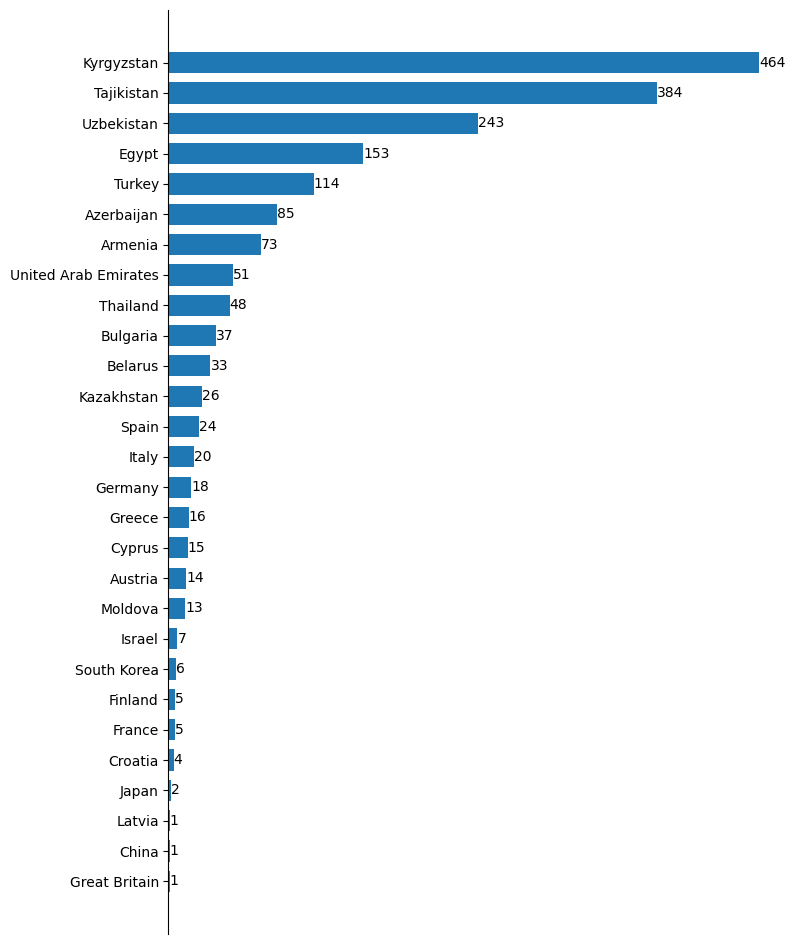

In [91]:
fig, ax = plt.subplots(figsize=(8,12))

# горизонтальная гистограмма
my_barh = plt.barh(countries['DEST_COUNTRY'], countries['ISSUE_DATE'],
                   height=0.7 # толщина столбца
                   )

ax.spines[['right', 'top', 'bottom']].set_visible(False)
ax.xaxis.set_visible(False)
ax.bar_label(my_barh)
plt.show()


**3) Функция, принимающая на вход город и строящая круговую диаграмму направлений вылета из данного города**



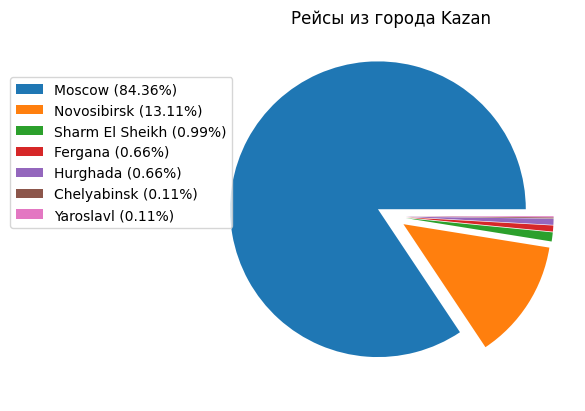

In [ ]:
def flights_in_the_city(city):
    data = df[df['ORIG_CITY'] == city].groupby('DEST_CITY', as_index=False)['ISSUE_DATE'].count().sort_values('ISSUE_DATE', ascending=False)

    # заголовок
    plt.title(f'Рейсы из города {city}')

    names = data['DEST_CITY']
    values = data['ISSUE_DATE']

    # в окне с подписями будут отображаться проценты
    total = sum(values)
    names = [f"{n} ({v/total:.2%})" for n, v in zip(names, values)]

    # Отодвинуть секторы от центра круга
    explode = [0.1] * len(values)
    plt.pie(values, explode=explode)


    plt.legend(bbox_to_anchor=(-0.16, 0.45, 0.25, 0.25), # координаты окошка с подписями
               loc='best', # расположение окошка
               labels=names) # сами подписи

flights_in_the_city('Kazan')

**4) За сколько времени люди покупают билеты?**



In [ ]:
print(df['ISSUE_DATE'].min(), df['ISSUE_DATE'].max())
print(df['FLIGHT_DATE_LOC'].min(), df['FLIGHT_DATE_LOC'].max())

2021-10-01 00:00:00 2022-09-30 00:00:00
2021-10-01 00:00:00 2022-10-05 00:00:00


->  У нас данные о покупках билетов с 1 октября 2021 по 30 сентября 2022

-> У нас данные о вылетах с 1 октября 2021 по 5 октября 2022

In [ ]:
print(df['ISSUE_DATE'].dt.hour.unique())
print(df['FLIGHT_DATE_LOC'].dt.hour.unique())

[0]
[0]


-> у нас нет конкретного времени покупки и рейса, есть только дата

In [ ]:
raznica = (df['FLIGHT_DATE_LOC'] - df['ISSUE_DATE']).apply(lambda x: x.days)
raznica # разница в днях между рейсом и покупкой

0        35
1         3
2        37
3        28
4        35
         ..
49841    11
49842    14
49843     3
49844     2
49845    16
Length: 49846, dtype: int64

In [ ]:
print(raznica.quantile(0), raznica.quantile(1)) # размах всех данных
print(raznica.quantile(0.25), raznica.quantile(0.5), raznica.quantile(0.75)) # нижняя квартиль, медиана, верхняя

0.0 317.0
3.0 9.0 25.0


In [ ]:
# граница верхнего уса
top_line = raznica.quantile(0.75) + 1.5 * (raznica.quantile(0.75) - raznica.quantile(0.25))
top_line

58.0

<Axes: >

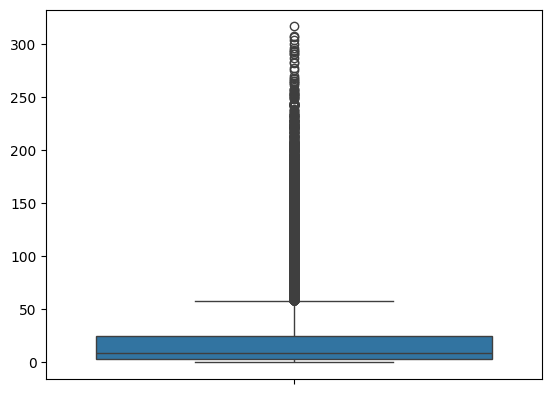

In [ ]:
sns.boxplot(raznica)
#  слева на графике количество дней
# размах данных от 0 до 317
# основная часть данных находится в интервале от 0 до 58 дней
# четверть всех билетов куплена в интервале от 0 до 3 дней
# половина всех билетов покупают за 9 дней  до вылета и ранее

In [ ]:
# еще один вариант ящика с усами
import plotly.express as px
px.box(raznica, points = 'all')

In [ ]:
# сколько % билетов покупаются заранее
len(raznica[raznica > top_line]) / len(raznica)

0.09009750030092685

In [ ]:
# сколько % билетов покупаются в те же сутки
len(raznica[raznica == 0]) / len(raznica)

0.02700316976286964

Вывод: основная часть билетов в интервале от 0 до 58 дней; четверть всех билетов куплена в интервале от 0 до 3 дней; половину всех билетов покупают за 9 дней до вылета и ранее; только 9 % билетов покупаются сильно заранее(до 317 дней); 3% билетов покупаются менее чем за сутки до вылета

5) Во все месяца летают одинаково?

In [53]:
# добавили 2 новых столбца, месяц и год рейса
df['FLIGHT_MONTH'] = df['FLIGHT_DATE_LOC'].dt.month
df['FLIGHT_YEAR'] = df['FLIGHT_DATE_LOC'].dt.year

In [54]:
df.head()

,ISSUE_DATE,FLIGHT_DATE_LOC,PAX_TYPE,REVENUE_AMOUNT,FOP_TYPE_CODE,ORIG_CITY_CODE,DEST_CITY_CODE,ROUTE_FLIGHT_TYPE,FFP_FLAG,SALE_TYPE,FLIGHT_MONTH,FLIGHT_YEAR
0,2021-12-07,2022-01-11,AD,200,CA,MOW,KGD,ВВЛ,False,ONLINE,1,2022
1,2021-12-31,2022-01-03,AD,610,CA,UUS,OVB,ВВЛ,False,OFFLINE,1,2022
2,2021-11-28,2022-01-04,AD,390,"CA,FS,IN",KGD,MOW,ВВЛ,True,ONLINE,1,2022
3,2021-12-08,2022-01-05,AD,190,CA,VOZ,MOW,ВВЛ,False,ONLINE,1,2022
4,2021-12-08,2022-01-12,AD,190,CA,MOW,KRR,ВВЛ,True,OFFLINE,1,2022


In [55]:
month_year = df.groupby(['FLIGHT_YEAR', 'FLIGHT_MONTH'], as_index=False)['ISSUE_DATE'].count() # группируем данные по году и месяцу, считаем количество рейсов в каждом месяце

In [56]:
month_year

,FLIGHT_YEAR,FLIGHT_MONTH,ISSUE_DATE
0,2021,10,1749
1,2021,11,4599
2,2021,12,4216
3,2022,1,5179
4,2022,2,2284
5,2022,3,3665
6,2022,4,4242
7,2022,5,2481
8,2022,6,3590
9,2022,7,4644


In [92]:
# Так как у нас данные о вылетах заканчиваются 5 октября 2022, удалим запись о количестве рейсов в октябре 2022
month_year = month_year.drop(12)

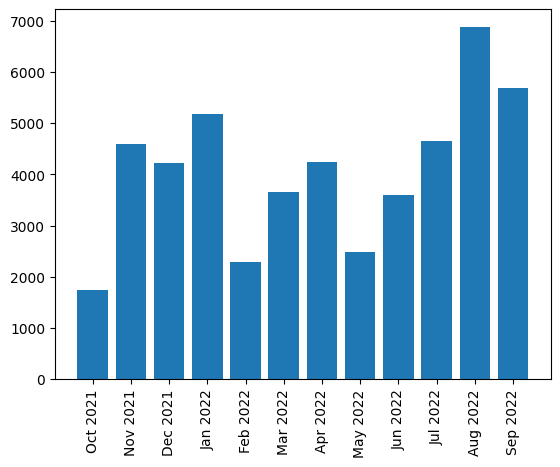

In [93]:
import calendar

plt.bar(month_year.index, month_year['ISSUE_DATE'])

months = list(calendar.month_abbr)

labels = month_year.apply(lambda row: f'{months[row.FLIGHT_MONTH]} {row.FLIGHT_YEAR}', axis=1)
plt.xticks(month_year.index, labels, rotation=90)

plt.show()

Вывод: октябрь 2021, февраль 2022, май 2022 - месяца с самым низким количеством рейсов; август 2022 и сентябрь 2022 - месяца с самым высоким количеством рейсов.